In [16]:
import matplotlib.pyplot as plt
import numpy as np

# from scipy.integrate import solve_ivp

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'notebook',
])

In [17]:
Ts = 4
tf = 10000

iterations = int(tf / Ts)

time = np.linspace(0, tf, iterations)

r = 31
mu = 40
sigma = 55
A2 = np.pi * r ** 2

Kb = 16

In [18]:
z1_bounds = np.load('./data/z1_bounds.npy')
z2_bounds = np.load('./data/z2_bounds.npy')
z3_bounds = np.load('./data/z3_bounds.npy')


def M1(Z1):
    return (z1_bounds[1] - Z1) / (z1_bounds[1] - z1_bounds[0])


def N1(Z2):
    return (z2_bounds[1] - Z2) / (z2_bounds[1] - z2_bounds[0])


def O1(Z3):
    return (z3_bounds[1] - Z3) / (z3_bounds[1] - z3_bounds[0])


def M2(Z1):
    return 1 - M1(Z1)


def N2(Z2):
    return 1 - N1(Z2)


def O2(Z3):
    return 1 - O1(Z3)


pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [O1, O2]
])

In [19]:
h1_t = np.zeros(iterations)
h2_t = np.zeros(iterations)

h1_0 = 20
h2_0 = 12.85
 
h1_t[0] = h1_0
h2_t[0] = h2_0

h1 = h1_0
h2 = h2_0

n = 8

A_matrices = [np.load(f'./data/vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./data/vertices/B_{i}.npy') for i in range(n)]

u = np.zeros(iterations)

u[:int(2500 / Ts)] = 25
u[int(2500 / Ts):int(5000 / Ts)] = 35
u[int(5000 / Ts):int(7500 / Ts)] = 30
u[int(7500 / Ts):int(10000 / Ts)] = 40


def R_34(diff):
    return -0.000071183*diff**2 + 0.002279342*diff + 0.009212421

def q_out(h4):
    return -0.049605*h4**2+10.759176*h4+157.705535


for i in range(1, iterations):
    t = time[i]

    H = np.array([
        [h1],
        [h2]
    ])

    diff = h1 - h2

    R34 = 0.73835215*R_34(diff)
    qout = 1.39518809*q_out(h2)

    a3 = (3 * r / 5) * (2.7 * r - ((np.cos(2.5*np.pi*(h1 - 8.) - mu)) / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(((h1 - 8.) - mu)**2) / (2 * sigma ** 2)))

    Z1 = 1/R34
    Z2 = qout/h2
    Z3 = 1/a3
    
    mf_system = np.array([
        [pertinence_functions[0, 1](Z1), pertinence_functions[0, 0](Z1)],
        [pertinence_functions[1, 1](Z2), pertinence_functions[1, 0](Z2)],
        [pertinence_functions[2, 1](Z3), pertinence_functions[2, 0](Z3)],
    ])

    W = np.array([
        mf_system[0, 1] * mf_system[1, 1] * mf_system[2, 1],
        mf_system[0, 1] * mf_system[1, 1] * mf_system[2, 0],
        mf_system[0, 1] * mf_system[1, 0] * mf_system[2, 1],
        mf_system[0, 1] * mf_system[1, 0] * mf_system[2, 0],
        mf_system[0, 0] * mf_system[1, 1] * mf_system[2, 1],
        mf_system[0, 0] * mf_system[1, 1] * mf_system[2, 0],
        mf_system[0, 0] * mf_system[1, 0] * mf_system[2, 1],
        mf_system[0, 0] * mf_system[1, 0] * mf_system[2, 0],
    ])

    Ai = sum([A_matrices[j] * W[j] for j in range(n)])
    Bi = sum([B_matrices[j] * W[j] for j in range(n)])

    delta_sys = Ai @ H + Bi * u[i]

    h1 += delta_sys[0, 0] * Ts
    h2 += delta_sys[1, 0] * Ts

    h1_t[i] = h1
    h2_t[i] = h2

In [20]:
h1_exp = np.load('./data/h1_exp.npy')[:-1]
h2_exp = np.load('./data/h2_exp.npy')[:-1]
t_exp = np.load('./data/exp_t.npy')[:-1]

h1_nl = np.load('./data/h1_nl.npy')
h2_nl = np.load('./data/h2_nl.npy')

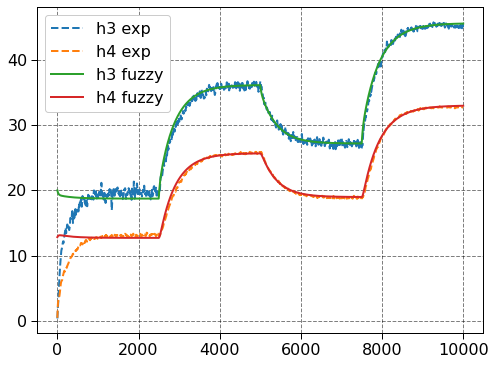

In [21]:
plt.figure(1)

plt.plot(t_exp, h1_exp, '--', label='h3 exp')
plt.plot(t_exp, h2_exp, '--', label='h4 exp')

plt.plot(time, h1_t, label='h3 fuzzy')
plt.plot(time, h2_t, label='h4 fuzzy')

plt.legend()
plt.savefig('./fuzzy.png', dpi=300)

# plt.plot(t_exp, h1_exp)
# plt.plot(t_exp, h2_exp)

In [22]:
np.save('./data/h3_py.npy', h1_t)
np.save('./data/h4_py.npy', h2_t)